# ROZDZIAL 3 - KLASYFIKACJA

## Zbior danych MNIST

In [1]:
import tensorflow as tf
from tensorflow import keras

In [2]:
mnist = keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
X_train.shape, y_train

((60000, 28, 28), array([5, 0, 4, ..., 5, 6, 8], dtype=uint8))

In [4]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [5]:
some_digt = X_train[3600]

In [6]:
some_digt_2 = X_train[11]

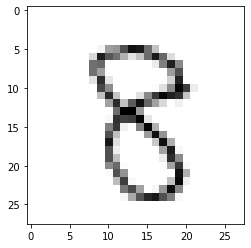

In [7]:
plt.imshow(some_digt, cmap=mpl.cm.binary, interpolation="nearest")

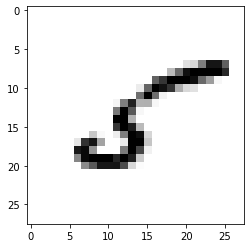

In [8]:
plt.imshow(some_digt_2, cmap=mpl.cm.binary, interpolation="nearest")

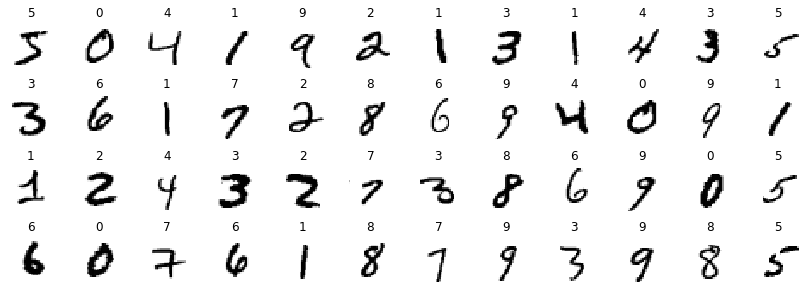

In [9]:
n_rows = 4
n_cols = 12
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap=mpl.cm.binary, interpolation="nearest")
        plt.axis('off')
        plt.title(y_train[index], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [10]:
import numpy as np

In [11]:
shuffle_index = np.random.permutation(X_train.shape[0])

In [12]:
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index] # przetasowanie indeksów"

In [13]:
nsamples, nx, ny = X_train.shape
d2_X_train = X_train.reshape((nsamples,nx*ny))

## Klasyfiktaor binarny

In [14]:
# klasyfikacja jedynie piatek
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [15]:
y_test_5

array([False, False, False, ..., False,  True, False])

In [16]:
from sklearn.linear_model import SGDClassifier

In [17]:
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42) # klasyfikator stochastycznego spadku wzdluz gradinetu
sgd_clf.fit(d2_X_train, y_train_5)

SGDClassifier(random_state=42)

In [18]:
sgd_clf.predict([some_digt.reshape((nx*ny,))]) # przewiduje wyswietlona 8

array([False])

In [19]:
sgd_clf.predict([some_digt_2.reshape((nx*ny,))]) # przewiduje wyswietlona piatke

array([ True])

## Miary wydajności

In [20]:
from sklearn.model_selection import cross_val_score

In [21]:
cross_val_score(sgd_clf, d2_X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9614 , 0.95935, 0.9614 ])

In [22]:
# Własna implementacja cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [23]:
skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(d2_X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = d2_X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = d2_X_train[test_index]
    y_test_fold = y_train_5[test_index]
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9625
0.94245
0.97005


In [24]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [25]:
# XD bo tylko 10% danych to piatki
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, d2_X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91025, 0.9075 , 0.9112 ])

## Macierz pomylek

In [26]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import  confusion_matrix

In [27]:
y_train_pred = cross_val_predict(sgd_clf, d2_X_train, y_train_5, cv=3)

In [28]:
confusion_matrix(y_train_5, y_train_pred)

array([[53932,   647],
       [ 1710,  3711]])

In [29]:
# TN  FP
# FN  TP

## Precyzja i Pelnosc

In [30]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [31]:
precision_score(y_train_5, y_train_pred)

0.851537402478201

In [32]:
recall_score(y_train_5, y_train_pred)

0.6845600442722745

In [33]:
f1_score(y_train_5, y_train_pred)

0.7589733101544124

## Komporomis pomiedzy precyzja a pelnoscia

In [34]:
y_scores = sgd_clf.decision_function([some_digt_2.reshape((nx*ny,))]) # przewiduje wyswietlona 5
y_scores

array([2816.32035023])

In [35]:
threshold = 2000
y_some_digit_predic = (y_scores > threshold)
y_some_digit_predic

array([ True])

In [36]:
threshold = 5000
y_some_digit_predic = (y_scores > threshold)
y_some_digit_predic

array([False])

In [37]:
y_scores = cross_val_predict(sgd_clf, d2_X_train, y_train_5, cv=3, method="decision_function")

In [38]:
from sklearn.metrics import precision_recall_curve

In [39]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [40]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precyzja", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Pełność", linewidth=2)
    plt.legend(fontsize=16)
    plt.grid(True)
    plt.xlabel("Próg", fontsize=16)

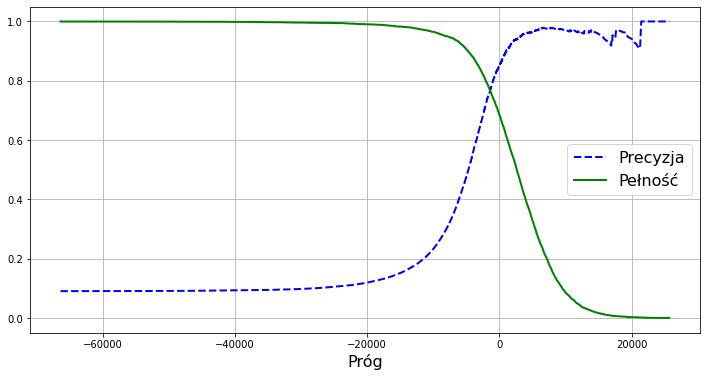

In [41]:
plt.figure(figsize=(12, 6))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [42]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Pełność", fontsize=16)
    plt.ylabel("Precyzja", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

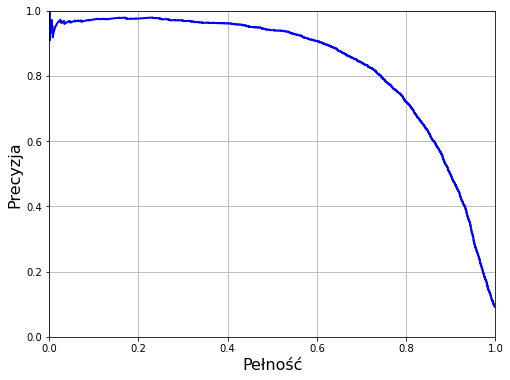

In [43]:
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()